In [639]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import itertools
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from sklearn.preprocessing import minmax_scale
cmap = cm.coolwarm

# Gaussian Distribution

In [329]:
w = 50
x, y = np.meshgrid(np.linspace(-3,3,w), np.linspace(-3,3,w))
mean1 = np.array([0,0])
cov1 = np.array([[1,0],
                [0,1]])

mean2 = np.array([0,0])
cov2 = np.array([[1,.8],
                [.8,1]])

In [330]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx
    

def plot_gaussian(fig, pos, x,y, mean, cov, condX = 0, condY = 0):

    linewidths = 2
    
    gauss = multivariate_normal(mean,cov)
    
    z = np.vectorize(lambda a, b: gauss.pdf((a,b)))(x,y)
    
    ax = fig.add_subplot(pos, projection='3d', proj_type='ortho', elev=35, azim=25, zlim3d=(-0.4,0.3), xlabel='X', ylabel='Y', zlabel='Density')
    
    # 3d density
    ax.plot_surface(x, y, z, cmap=cmap, )

    # 2d heatmap
    cset = ax.contourf(x, y, z, zdir='z', offset=-0.4, cmap=cmap)
    
    # conditionals
    gauss_cx = multivariate_normal(mean[0] + (cov[0,1]/cov[1,1])*(condX-mean[1]), cov[0,0] - (cov[0,1]*cov[1,0])/cov[1,1])
    cx = np.tile( gauss_cx.pdf(x[0,:]), (50,1))/1
    ax.contour(x, y, cx, zdir='y', offset=-3, levels=[-100, 0], colors=[cmap(0.99)], linewidths=linewidths)
    
    gauss_cy = multivariate_normal(mean[1] + (cov[1,0]/cov[0,0])*(condY-mean[0]), cov[1,1] - (cov[1,0]*cov[0,1])/cov[0,0])
    cy = np.tile( gauss_cy.pdf(y[:,0]), (50,1)).T/1
    ax.contour(x, y, cy, zdir='x', offset=-3, levels=[-100, 0], colors=[cmap(0)], linewidths=linewidths)
        
    # marginals
    gauss_mx = multivariate_normal(mean[0],cov[0,0])
    mx = np.tile( gauss_mx.pdf(x[0,:]), (50,1))/1
    cset = ax.contour(x, y, mx, zdir='y', offset=-3, levels=[0, 100], colors=['black'], linewidths=linewidths, linestyles='dotted')
    gauss_my = multivariate_normal(mean[1],cov[1,1])
    my = np.tile( gauss_mx.pdf(y[:,0]), (50,1)).T/1
    #my = np.tile(np.mean(z, axis=1), (50,1)).T/1
    cset = ax.contour(x, y, my, zdir='x', offset=-3, levels=[0, 100], colors=['black'],  linewidths=linewidths, linestyles='dotted')
    
    custom_lines = [Line2D([0], [0], color='black', lw=3, linestyle='dotted'),
                    Line2D([0], [0], color=cmap(0.99), lw=3),
                    Line2D([0], [0], color=cmap(0), lw=3)]

    ax.legend(custom_lines, ['Marginals', 'P(X | Y = %.1f)'%condY, 'P(Y | X = %.1f)'%condX])

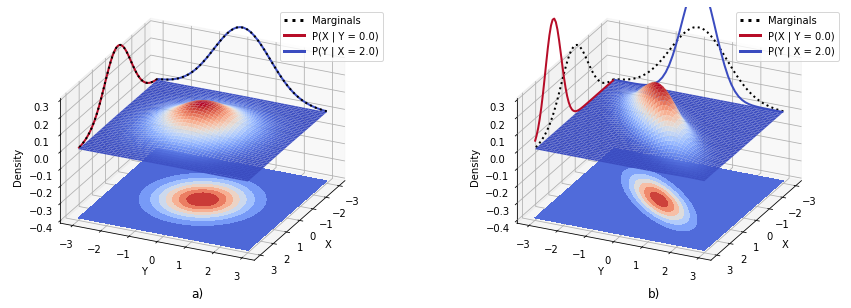

In [336]:
fig = plt.figure(figsize=(15,5))
plot_gaussian(fig, 121, x,y, mean1, cov1, condX=2, condY=0)
plot_gaussian(fig, 122, x,y, mean2, cov2, condX=2, condY=0)
fig.get_axes()[0].set_title('a)', y=-0.1)
fig.get_axes()[1].set_title('b)', y=-0.1);

# Gaussian Process

In [769]:
def partition(matrix, xIndices, yIndices):
    mesh = np.meshgrid(xIndices, yIndices)
    return matrix[mesh[0].ravel(), mesh[1].ravel()].reshape(mesh[0].shape)
    

def plot_gp(mean, cov, size=1, condOn=None, cond=None):
    assert (condOn is None or len(condOn) == len(cond) or isinstance(cond, str) or isinstance(cond, float)), 'condOn and cond must have same length'
    if condOn is None: cond = None
    if condOn is not None:
        assert isinstance(condOn, list) and len(condOn) > 0, 'condOn should not be an empty list - pass None instead'
        
        cond = np.asarray(cond).reshape(-1,1)

        condMask = np.zeros(len(mean), dtype=np.bool)
        condMask[condOn] = 1
        notCondOn = np.arange(len(mean))[condMask == False]

        meanA = mean[notCondOn].reshape(-1,1)
        meanB = mean[condOn].reshape(-1,1)

        covBB = partition(cov, condOn, condOn)
        covBA = partition(cov, notCondOn, condOn)
        covAB = partition(cov, condOn, notCondOn)
        covAA = partition(cov, notCondOn, notCondOn)

        _mean = meanA + np.matmul(np.matmul(covAB, np.linalg.inv(covBB)), (cond-meanB)) 
        _cov = covAA - np.matmul(np.matmul(covAB, np.linalg.inv(covBB)), covBA)
    else:
        _mean = mean.reshape(-1,1)
        _cov = cov
        
    c = np.random.multivariate_normal(_mean.ravel(), _cov, size=size)
    
    s = np.zeros(len(mean))
    if cond is not None:
        s[condOn] = cond.ravel()
        s[notCondOn] = c.ravel()
    else: 
        s[:] = c.ravel()
    return s



def plot_samples(fig, ax, mean, cov, condOn=None, cond=None, n_samples = 50,):
    assert (condOn is None or len(condOn) == len(cond) or isinstance(cond, str) or isinstance(cond, float)), 'condOn and cond must have same length'
    if condOn is not None and isinstance(cond, (str, float)):
        cond = [cond]*len(condOn)
    ax[0].set_prop_cycle(color=[cm.coolwarm(i) for i in np.linspace(0,0.99,n_samples)])
    for i in np.linspace(-1,1,n_samples):
        if condOn is not None:
            _cond = [i if c == 'linear' else c for c in cond]
        else: 
            _cond = None
        ax[0].plot(plot_gp(mean, cov, condOn=condOn, cond=_cond ))
        ax[0].set_xticks(np.arange(D))
        ax[0].set_xticklabels(['$X_%i$'%i for i in range(D)])
        ax[0].set_ylim(-3,3)
    im = ax[1].imshow(cov, cmap=cm.coolwarm, vmin=-1, vmax=1)
    fig.colorbar(im, ax = ax[1])

    

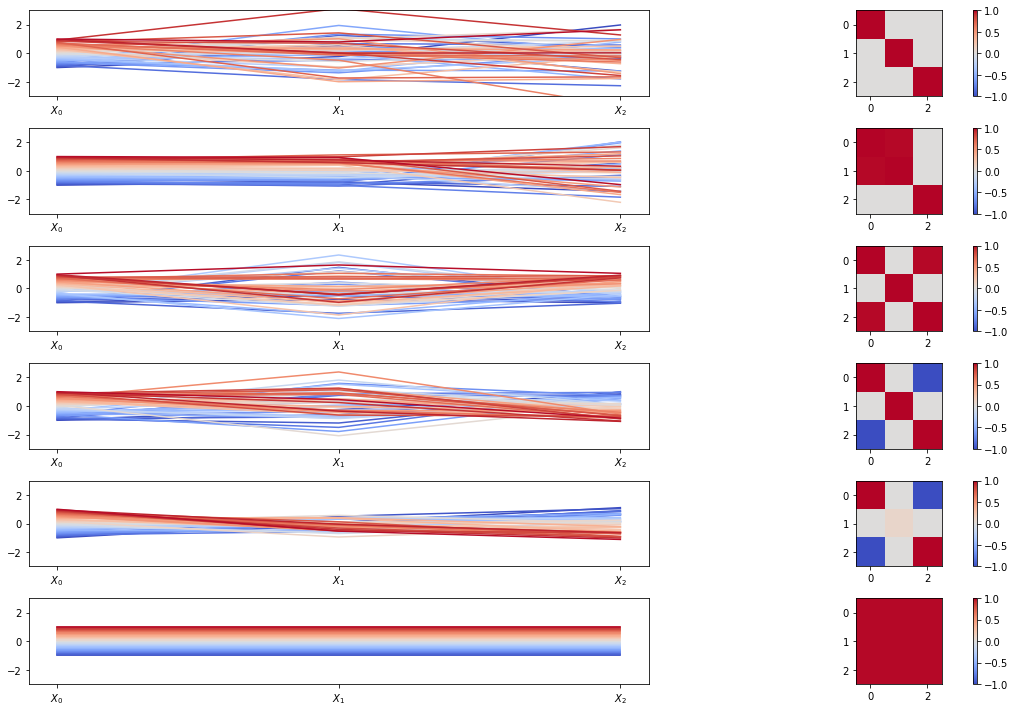

In [770]:
D = 3
mean = np.zeros(D)
cov = np.eye(D)
    
fig, ax = plt.subplots(6,2, figsize=(15,10))

plot_samples(fig, ax[0], mean, cov, condOn=[0], cond='linear')
cov = np.eye(D); cov[0,1] = cov[1,0] = 0.99
plot_samples(fig, ax[1], mean, cov, condOn=[0], cond='linear')
cov = np.eye(D); cov[0,2] = cov[2,0] = 0.99
plot_samples(fig, ax[2], mean, cov, condOn=[0], cond='linear')
cov = np.eye(D); cov[0,2] = cov[2,0] = -0.99
plot_samples(fig, ax[3], mean, cov, condOn=[0], cond='linear')
cov = np.eye(D); cov[0,2] = cov[2,0] = -0.99; cov[1,1] = 0.1
plot_samples(fig, ax[4], mean, cov, condOn=[0], cond='linear')
cov = np.ones((D,D))*0.99;
plot_samples(fig, ax[5], mean, cov, condOn=[0], cond='linear')

plt.tight_layout()

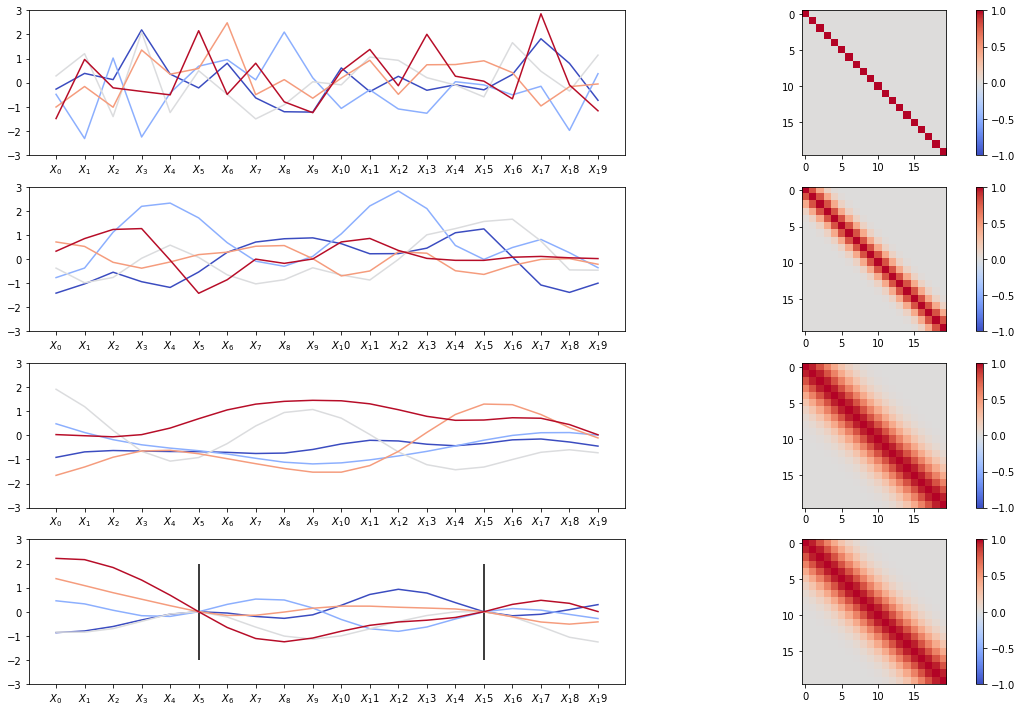

In [780]:
from sklearn.gaussian_process.kernels import RBF

D = 20
mean = np.zeros(D)
    
fig, ax = plt.subplots(4,2, figsize=(15,10))

cov = np.eye(D);
plot_samples(fig, ax[0], mean, cov, n_samples=5)

kernel = RBF(length_scale=1.5)
cov = kernel(np.arange(D).reshape(-1,1))
plot_samples(fig, ax[1], mean, cov, n_samples=5)

kernel = RBF(length_scale=3)
cov = kernel(np.arange(D).reshape(-1,1))
plot_samples(fig, ax[2], mean, cov, n_samples=5)

kernel = RBF(length_scale=3)
cov = kernel(np.arange(D).reshape(-1,1))
plot_samples(fig, ax[3], mean, cov, condOn=[5,15], cond=[0, 0], n_samples=5)
ax[3][0].vlines([5,15],-2,2)

plt.tight_layout()